In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import emcee
from scipy.stats import norm
import corner
import scienceplots

In [2]:
df = pd.read_excel('spectral parameter J1655 R05.xlsx')

In [3]:
bmc = df['norm_bmc']
alpha = df['alpha']

gamma = [a + 1 for a in alpha]

def scaling(Nbmc, A, B, Ntr, beta):
    f = A - B * np.log(np.exp(1 - (Nbmc/Ntr)**beta) + 1)
    return f

In [4]:
obs_id_cut = df.obs_id_cut
for i, obs_id in enumerate(obs_id_cut):
    print(f'Data point {i + 1}: obs_id_cut = {obs_id}')

Data point 1: obs_id_cut = 90058-16-02-00_16_0
Data point 2: obs_id_cut = 90058-16-02-00_16_1
Data point 3: obs_id_cut = 90058-16-02-00_16_2
Data point 4: obs_id_cut = 90058-16-03-00_16_0
Data point 5: obs_id_cut = 90058-16-03-00_16_1
Data point 6: obs_id_cut = 90058-16-03-00_16_2
Data point 7: obs_id_cut = 90058-16-04-00_16_0
Data point 8: obs_id_cut = 90058-16-04-00_16_1
Data point 9: obs_id_cut = 90058-16-04-00_16_2
Data point 10: obs_id_cut = 90058-16-05-00_16_0
Data point 11: obs_id_cut = 90058-16-05-00_16_1
Data point 12: obs_id_cut = 90058-16-05-00_16_2
Data point 13: obs_id_cut = 90058-16-06-00_16_0
Data point 14: obs_id_cut = 90058-16-06-00_16_1
Data point 15: obs_id_cut = 90058-16-07-00_16_0
Data point 16: obs_id_cut = 90058-16-07-00_16_1
Data point 17: obs_id_cut = 90058-16-07-00_16_2
Data point 18: obs_id_cut = 90058-16-07-00_16_3
Data point 19: obs_id_cut = 90428-01-01-00_16_0
Data point 20: obs_id_cut = 90428-01-01-00_16_1
Data point 21: obs_id_cut = 90428-01-01-00_16_2
D

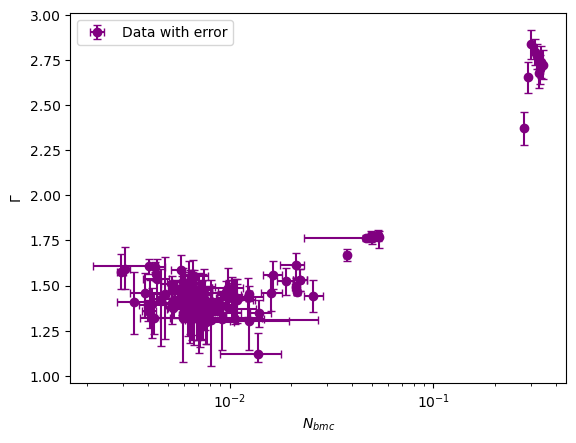

In [5]:
# Data for norm_bmc and alpha
bmc = df['norm_bmc']
gamma = [a + 1 for a in df['alpha']]

# Convert err columns to numeric to avoid string errors
df['err_norm_bmc_p'] = pd.to_numeric(df['err_norm_bmc_p'], errors='coerce')
df['err_norm_bmc_m'] = pd.to_numeric(df['err_norm_bmc_m'], errors='coerce')
df['err_alpha_p'] = pd.to_numeric(df['err_alpha_p'], errors='coerce')
df['err_alpha_m'] = pd.to_numeric(df['err_alpha_m'], errors='coerce')

# err values
err_bmc_p = df['err_norm_bmc_p']
err_bmc_m = df['err_norm_bmc_m']
err_gamma_p = df['err_alpha_p']
err_gamma_m = df['err_alpha_m']

# Plotting the data with err bars
plt.errorbar(bmc, gamma, 
             xerr=[np.abs(err_bmc_m), err_bmc_p], 
             yerr=[np.abs(err_gamma_m), err_gamma_p], 
             fmt='o', color='purple', capsize=3, label='Data with error')

# Configure plot appearance
plt.xscale('log')
plt.xlabel('$N_{bmc}$')
plt.ylabel(r'$\Gamma$')
plt.legend()
plt.show()


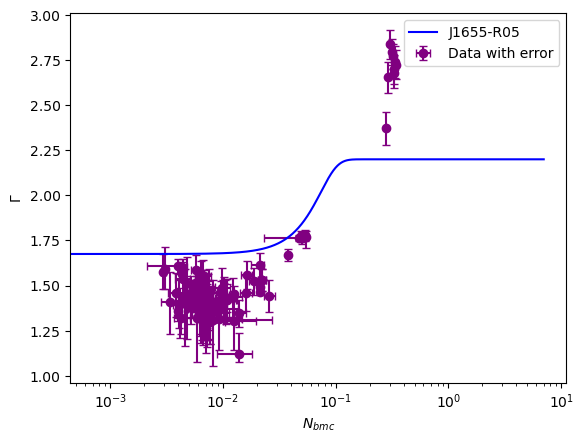

In [6]:
A1 = 2.2
B1 = 0.4
Ntr1 = 0.061 
beta1 = 2.3

# Generate Nbmc values for the function
Nbmc1 = np.linspace(0, 7, 10000) 

# Compute scaling functions
f1 = scaling(Nbmc1, A1, B1, Ntr1, beta1)

# Plotting the data and models without err bars
plt.errorbar(bmc, gamma, 
             xerr=[np.abs(err_bmc_m), err_bmc_p], 
             yerr=[np.abs(err_gamma_m), err_gamma_p], 
             fmt='o', color='purple', capsize=3, label='Data with error')
plt.plot(Nbmc1, f1, label='J1655-R05', color='blue')

# Configure plot appearance
plt.xscale('log')
plt.xlabel('$N_{bmc}$')
plt.ylabel(r'$\Gamma$')
plt.legend()


# Show the plot
plt.show()

In [7]:
# Convert gamma (list) to a NumPy array for consistent indexing
gamma = np.array(gamma)

# Combine the mask to filter out NaN and inf values for bmc and gamma and their error
mask = (
    np.isfinite(bmc) & np.isfinite(gamma) &
    np.isfinite(err_bmc_m) & np.isfinite(err_bmc_p) &
    np.isfinite(err_gamma_m) & np.isfinite(err_gamma_p)
)

# Apply the mask to clean the data
bmc_clean = bmc[mask]
gamma_clean = gamma[mask]
err_bmc_m_clean = err_bmc_m[mask]
err_bmc_p_clean = err_bmc_p[mask]
err_gamma_m_clean = err_gamma_m[mask]
err_gamma_p_clean = err_gamma_p[mask]

In [8]:
# Define the scaling function
def scaling(Nbmc, A, B, Ntr, beta):
    return A - B * np.log(np.exp(1 - (Nbmc/Ntr)**beta) + 1)

# Define the log-likelihood function
def log_likelihood(theta, x, y, yerr_x, yerr_y):
    A, B, Ntr, beta = theta
    model = scaling(x, A, B, Ntr, beta)

    # Variance for likelihood
    sigma2 = (yerr_y**2 + (B * (yerr_x / x))**2)  # Include error for x (bmc) and y (gamma)
    chi2 = np.sum((y - model)**2 / sigma2)  # Chi-squared calculation
    return -0.5 * chi2, chi2  # Return both likelihood and chi2

# Define the log-prior function
def log_prior(theta):
    A, B, Ntr, beta= theta
    if 0 < A < 3 :
        p1 = 1/3
    else:
        p1 = 0.0
    if 0 < B < 1.5 :
        p2 = 1/1.5
    else:
        p2 = 0.0
    if 0 < Ntr < 0.1: 
        p3 = 1/0.1
    else:
        p3 = 0.0
    if 0 < beta < 4 :
        p4 = 1/4
    else:
        p4 = 0
    return np.log(p1*p2*p3*p4)

# Define the log-probability function
def log_probability(theta, x, y, yerr_x, yerr_y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf  # If the log prior is not finite, return -infinity
    
    log_like, chi2 = log_likelihood(theta, x, y, yerr_x, yerr_y)
    return lp + log_like  # Return only the log probability

# Set up the MCMC sampler
ndim, nwalkers = 4, 50
initial_guess = [2.5, 0.8, 0.05, 2]  # Initial guess for [A, B, Ntr, beta]
pos = [initial_guess + 1e-4 * np.random.randn(ndim) for _ in range(nwalkers)]

# Run the MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(bmc_clean, gamma_clean, err_bmc_m_clean, err_gamma_m_clean))
sampler.run_mcmc(pos, 20000, progress=True)

# Get the samples and remove burn-in
samples = sampler.get_chain(discard=100, thin=15, flat=True)

# Calculate the best-fit parameters and uncertainties
A_mcmc, B_mcmc, Ntr_mcmc, beta_mcmc = map(lambda v: (v[1], v[2] - v[1], v[1] - v[0]),
                                          zip(*np.percentile(samples, [16, 50, 84], axis=0)))



  0%|▏                                                                              | 32/20000 [00:02<23:22, 14.24it/s]C:\Users\telly\AppData\Local\Temp\ipykernel_24304\2644165129.py:34: RuntimeWarning: divide by zero encountered in log
  return np.log(p1*p2*p3*p4)
100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [21:51<00:00, 15.25it/s]


In [17]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
np.savetxt("samples GRO R05.txt".format(df['obs_id'][0]), np.c_[flat_samples[:, 0],flat_samples[:, 1],flat_samples[:, 2]])

In [10]:
# Calculate reduced chi-squared
final_params = samples[-1]
chi2_final = log_likelihood(final_params, bmc_clean, gamma_clean, err_bmc_m_clean, err_gamma_m_clean)[1]
dof = len(bmc_clean) - len(final_params)  # Number of data points minus number of parameters
reduced_chi2 = chi2_final / dof

# Generate a smooth Nbmc range for the fitted curve
Nbmc_fit = np.logspace(np.log10(min(bmc_clean)), np.log10(max(bmc_clean)), 1000)

# Calculate the fitted scaling function using MCMC parameters
gamma_fit = scaling(Nbmc_fit, A_mcmc[0], B_mcmc[0], Ntr_mcmc[0], beta_mcmc[0])

In [11]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))
print("Mean autocorrelation time: {0:.3f}".format(np.mean(sampler.get_autocorr_time())))

Mean acceptance fraction: 0.558
Mean autocorrelation time: 69.274


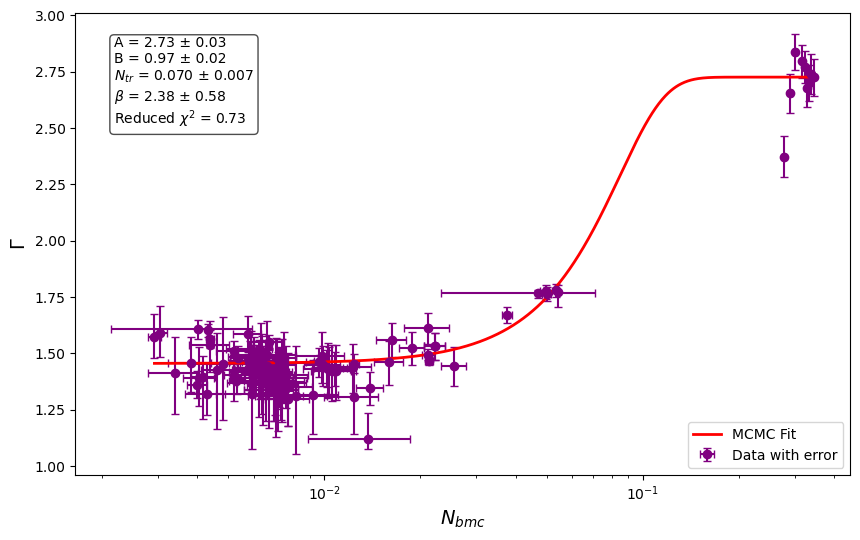

In [12]:
# Plotting the data and the fit
plt.figure(figsize=(10, 6))
plt.errorbar(bmc_clean, gamma_clean, 
             xerr=[np.abs(err_bmc_m_clean), err_bmc_m_clean], 
             yerr=[np.abs(err_gamma_m_clean), err_gamma_p_clean], 
             fmt='o', color='purple', capsize=3, label='Data with error')

plt.plot(Nbmc_fit, gamma_fit, color='red', label='MCMC Fit', lw=2)
plt.xscale('log')
plt.xlabel('$N_{bmc}$', fontsize=14)
plt.ylabel(r'$\Gamma$', fontsize=14)
# Add a text box with fitted parameters

param_text = (f'A = {A_mcmc[0]:.2f} ± {A_mcmc[1]:.2f}\n'
              f'B = {B_mcmc[0]:.2f} ± {B_mcmc[1]:.2f}\n'
              f'$N_{{tr}}$ = {Ntr_mcmc[0]:.3f} ± {Ntr_mcmc[1]:.3f}\n'
              f'$\\beta$ = {beta_mcmc[0]:.2f} ± {beta_mcmc[1]:.2f}\n'
              f'Reduced $\\chi^2$ = {reduced_chi2:.2f}')
plt.text(0.05, 0.95, param_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.legend(loc='lower right')
plt.show()

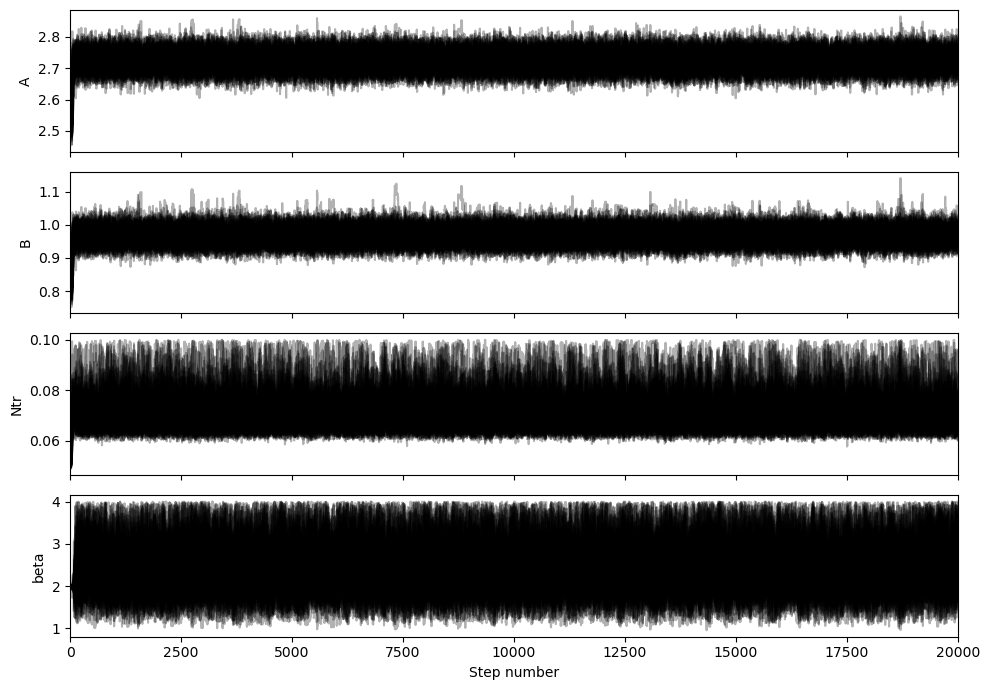

In [13]:
# Plot the trace for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples_full = sampler.get_chain()  # Get the full chain without thinning or discarding burn-in

# Labels for the parameters
labels = ["A", "B", "Ntr", "beta"]

# Plot each parameter's trace
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_full[:, :, i], "k", alpha=0.3)  # Plot each walker's chain in light black
    ax.set_xlim(0, len(samples_full))  # Set x-axis to the number of iterations
    ax.set_ylabel(labels[i])  # Set the y-axis label to the parameter's name

axes[-1].set_xlabel("Step number")  # Label the x-axis of the last plot

plt.tight_layout()
plt.show()

MCMC Results:
A = 2.725 +0.028 -0.027
B = 0.967 +0.023 -0.023
Ntr = 0.070 +0.007 -0.004
beta = 2.381 +0.582 -0.471
Reduced Chi-squared = 0.73


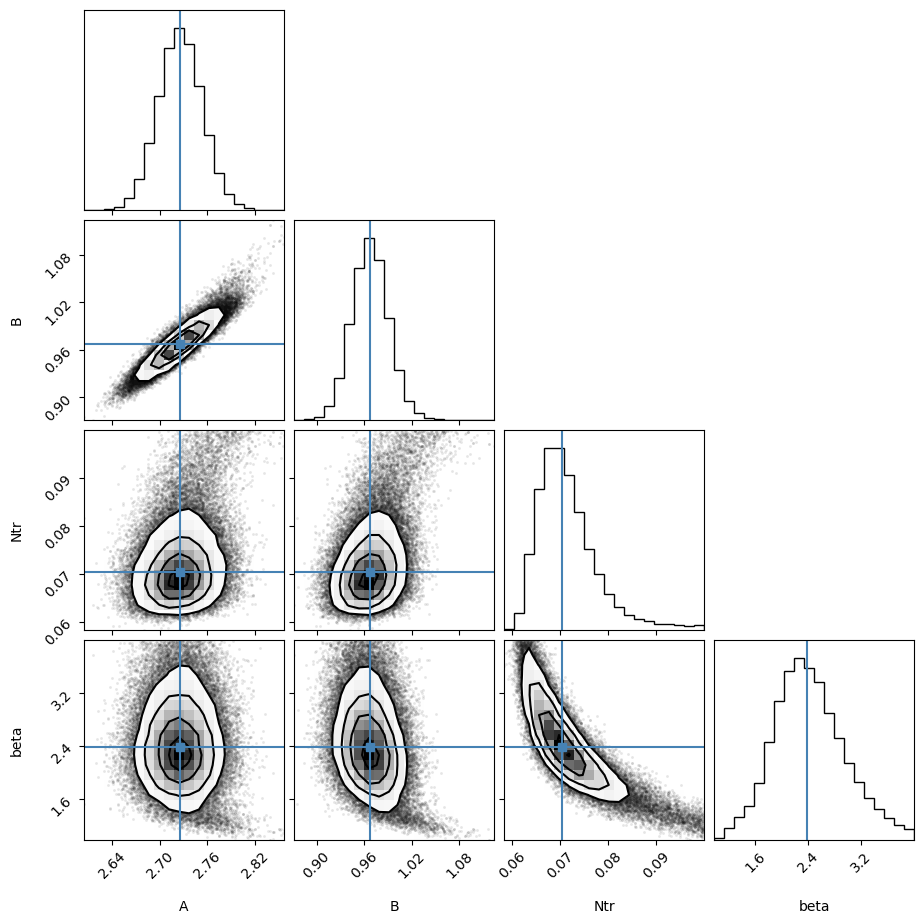

In [14]:
# Create corner plot
fig = corner.corner(samples, labels=["A", "B", "Ntr", "beta"],
                    truths=[A_mcmc[0], B_mcmc[0], Ntr_mcmc[0], beta_mcmc[0]])
# Print the MCMC results and reduced chi-squared
print("MCMC Results:")
print(f"A = {A_mcmc[0]:.3f} +{A_mcmc[1]:.3f} -{A_mcmc[2]:.3f}")
print(f"B = {B_mcmc[0]:.3f} +{B_mcmc[1]:.3f} -{B_mcmc[2]:.3f}")
print(f"Ntr = {Ntr_mcmc[0]:.3f} +{Ntr_mcmc[1]:.3f} -{Ntr_mcmc[2]:.3f}")
print(f"beta = {beta_mcmc[0]:.3f} +{beta_mcmc[1]:.3f} -{beta_mcmc[2]:.3f}")
print(f"Reduced Chi-squared = {reduced_chi2:.2f}")

In [15]:
# Calculate the fitted scaling function using MCMC parameters
gamma_f = scaling(bmc_clean, A_mcmc[0], B_mcmc[0], Ntr_mcmc[0], beta_mcmc[0])
np.savetxt('mcmc GRO R05 fit.txt', np.c_[gamma_clean, err_gamma_p_clean, err_gamma_m_clean, bmc_clean, err_bmc_p_clean, err_bmc_m_clean, gamma_f,], fmt='% 1.3f', header=' gamma err_gamma_p err_gamma_m bmc err_bmc_p err_bmc_m gamma_fit ')

In [16]:
# Calculate the largest err for each data point
largest_err_bmc = np.maximum(err_bmc_p, err_bmc_m)
largest_err_gamma = np.maximum(err_gamma_p, err_gamma_m)

# Find the index of the maximum err in either bmc or gamma
max_err_bmc_index = np.argmax(largest_err_bmc)
max_err_gamma_index = np.argmax(largest_err_gamma)

# Print the obs_id_cut corresponding to the maximum error
print(f'obs_id_cut with the largest err in norm_bmc: {df["obs_id_cut"].iloc[max_err_bmc_index]}')
print(f'obs_id_cut with the largest err in gamma: {df["obs_id_cut"].iloc[max_err_gamma_index]}')


obs_id_cut with the largest err in norm_bmc: 90704-04-01-01_16_2
obs_id_cut with the largest err in gamma: 90428-01-01-05_16_7
